In [1]:
!pip install patchify

import os
import glob
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import tensorflow as tf
import random

np.random.seed(0) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
PATH = '/content/drive/MyDrive/AV_split/'
TRAIN_PATH = PATH+'train/'
TRAIN_IMAGE_PATH = TRAIN_PATH + 'images/'
TRAIN_VESSEL_MASK_PATH = TRAIN_PATH + 'GT_vessel/'

TEST_PATH = PATH+'test/'
TEST_IMAGE_PATH = TEST_PATH + 'images/'
TEST_VESSEL_MASK_PATH = TEST_PATH + 'GT_vessel/'

PATCH_SIZE = 512

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def clahe_equalized(image):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    image_equalized = clahe.apply(image)

    return image_equalized

def preprocess_image(image, patch_size):
    image = image[70:970, 200:1255]

    image = image[:,:,1]
    image = clahe_equalized(image)

    SIZE_X = (image.shape[1]//patch_size)*patch_size 
    SIZE_Y = (image.shape[0]//patch_size)*patch_size     
    image = cv2.resize(image, (SIZE_X, SIZE_Y))
    
    image = image / 255.
    image = np.array(image)

    return image

In [5]:
def preprocess_vessel_mask(mask, patch_size):
    thresh = 128
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]

    mask = mask[70:970, 200:1255]
    
    SIZE_X = (mask.shape[1]//patch_size)*patch_size 
    SIZE_Y = (mask.shape[0]//patch_size)*patch_size     
    mask = cv2.resize(mask, (SIZE_X, SIZE_Y))
  
    mask = 255 - mask
    mask = mask / 255.

    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return mask

In [6]:
def image_to_patch(image_path, image_type, image_preprocessing, patch_size):
    image_dataset = unpatched_image = []

    if image_type == "IMAGE":
        image = cv2.imread(image_path)
    if image_type == "VESSEL_MASK":
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    image = image_preprocessing(image, patch_size)
    patches_image = patchify(image, (patch_size, patch_size), step=patch_size)
    unpatched_image = unpatchify(patches_image, image.shape)
    
    for i in range(patches_image.shape[0]):
        for j in range(patches_image.shape[1]):
            single_patch = patches_image[i,j,:,:]
            single_patch = (single_patch).astype('float32')
            image_dataset.append(single_patch)

    return image_dataset, unpatched_image

In [7]:
train_image_list = glob.glob(TRAIN_IMAGE_PATH + '/*.JPG')
train_image_list.sort()

train_vessel_mask_list = glob.glob(TRAIN_VESSEL_MASK_PATH + '/*.jpg')
train_vessel_mask_list.sort()

0.007843138 0.9843137
(2, 512, 512)


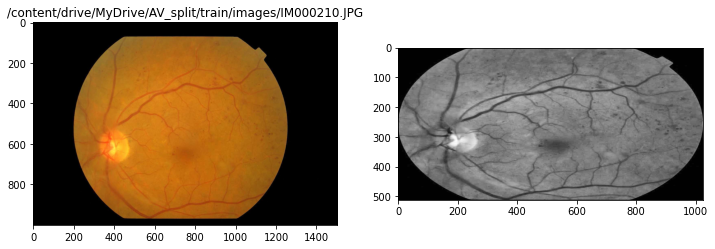

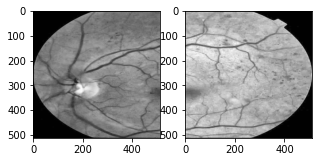

In [8]:
image_path = train_image_list[10]

original_image = cv2.imread(image_path)
patched_image_list, unpatched_image = image_to_patch(image_path, "IMAGE", preprocess_image, PATCH_SIZE)
patched_image = np.array(patched_image_list)

print(patched_image.min(), patched_image.max())
print(patched_image.shape)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(image_path)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(unpatched_image, cmap='gray')

plt.show()

rows = 1
columns = patched_image.shape[0]

fig = plt.figure(figsize=(5, 5))
for i in range(1, (rows * columns + 1)):
    fig.add_subplot(rows, columns, i)
    img = patched_image[i-1]
    plt.imshow(img,cmap='gray')

plt.show()

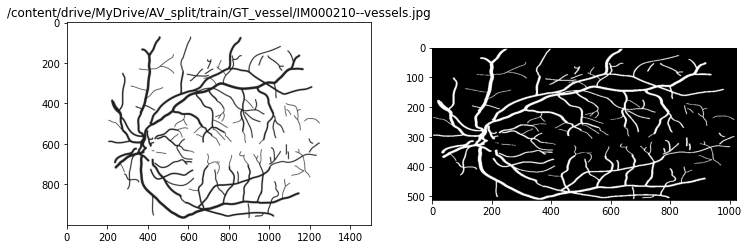

0.0 1.0
(2, 512, 512)
[0. 1.]


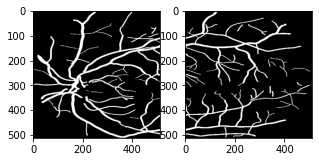

In [9]:
vessel_mask_path = train_vessel_mask_list[10]
original_vessel_mask = cv2.imread(vessel_mask_path, cv2.IMREAD_GRAYSCALE)

patched_mask_list, unpatcified_mask = image_to_patch(vessel_mask_path, "VESSEL_MASK", preprocess_vessel_mask, PATCH_SIZE)
patched_mask = np.array(patched_mask_list)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(vessel_mask_path)
plt.imshow(cv2.cvtColor(original_vessel_mask, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(unpatcified_mask, cmap='gray')

plt.show()

print(patched_mask.min(), patched_mask.max())
print(patched_mask.shape)
print(np.unique(patched_mask))

rows = 1
columns = patched_image.shape[0]

fig = plt.figure(figsize=(5, 5))
for i in range(1, (rows * columns + 1)):
    fig.add_subplot(rows, columns, i)
    img = patched_mask[i-1]
    plt.imshow(img,cmap='gray')

plt.show()

In [10]:
train_image_dataset = []
train_vessel_mask_dataset = []

for image_path in train_image_list:
    patched_image, unpatched_image = image_to_patch(image_path, "IMAGE", preprocess_image, PATCH_SIZE)
    train_image_dataset += patched_image

for vessel_mask_path in train_vessel_mask_list:
    patched_mask, unpatched_mask = image_to_patch(vessel_mask_path, "VESSEL_MASK", preprocess_vessel_mask, PATCH_SIZE)
    train_vessel_mask_dataset += patched_mask

train_image_dataset = np.array(train_image_dataset)
train_image_dataset = np.expand_dims(train_image_dataset, axis=-1)
train_vessel_mask_dataset = np.array(train_vessel_mask_dataset)
train_vessel_mask_dataset = np.expand_dims(train_vessel_mask_dataset, axis=-1)

print(train_image_dataset.shape)
print(train_vessel_mask_dataset.shape)
print(train_image_dataset.max(), train_vessel_mask_dataset.max())
print(train_image_dataset.min(), train_vessel_mask_dataset.min())

(50, 512, 512, 1)
(50, 512, 512, 1)
1.0 1.0
0.003921569 0.0


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_image_dataset, train_vessel_mask_dataset, test_size=0.3, random_state=0)

In [12]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(35, 512, 512, 1) (35, 512, 512, 1)
(15, 512, 512, 1) (15, 512, 512, 1)


In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

In [14]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = IoU_loss, metrics = ['accuracy', IoU_coef])
    

    if(pretrained_weights):
    	  model=keras.models.load_model(pretrained_weights)

    return model

In [15]:
model = unet(input_size=(PATCH_SIZE, PATCH_SIZE, 1))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
history = model.fit(x_train, y_train, 
                    verbose = 1,
                    batch_size = 3,
                    validation_data = (x_test, y_test), 
                    shuffle = False,
                    epochs = 150,
                    steps_per_epoch = 10)

Epoch 1/150
10/10 [==============================] - 41s 1s/step - loss: -0.0980 - accuracy: 0.1969 - IoU_coef: 0.0980 - val_loss: -0.0912 - val_accuracy: 0.1031 - val_IoU_coef: 0.0912
Epoch 2/150
10/10 [==============================] - 26s 3s/step - loss: -0.1001 - accuracy: 0.1282 - IoU_coef: 0.1002 - val_loss: -0.0906 - val_accuracy: 0.2537 - val_IoU_coef: 0.0906
Epoch 3/150
10/10 [==============================] - 13s 1s/step - loss: -0.1538 - accuracy: 0.8091 - IoU_coef: 0.1527 - val_loss: -0.0670 - val_accuracy: 0.8967 - val_IoU_coef: 0.0670
Epoch 4/150
10/10 [==============================] - 12s 1s/step - loss: -0.2340 - accuracy: 0.9045 - IoU_coef: 0.2337 - val_loss: -0.0477 - val_accuracy: 0.8986 - val_IoU_coef: 0.0477
Epoch 5/150
10/10 [==============================] - 12s 1s/step - loss: -0.2725 - accuracy: 0.9182 - IoU_coef: 0.2717 - val_loss: -0.0529 - val_accuracy: 0.8987 - val_IoU_coef: 0.0529
Epoch 6/150
10/10 [==============================] - 13s 1s/step - loss: -0

In [17]:
test_image_list = glob.glob(TEST_IMAGE_PATH + '/*.JPG')
test_image_list.sort()

test_vessel_mask_list = glob.glob(TEST_VESSEL_MASK_PATH + '/*.jpg')
test_vessel_mask_list.sort()

In [28]:
test_image_list = glob.glob(TEST_IMAGE_PATH + '/*.JPG')
test_image_list.sort()

test_vessel_mask_list = glob.glob(TEST_VESSEL_MASK_PATH + '/*.jpg')
test_vessel_mask_list.sort()

1/1 [==============================] - 0s 24ms/step
Execution time:  0:00:00.387107


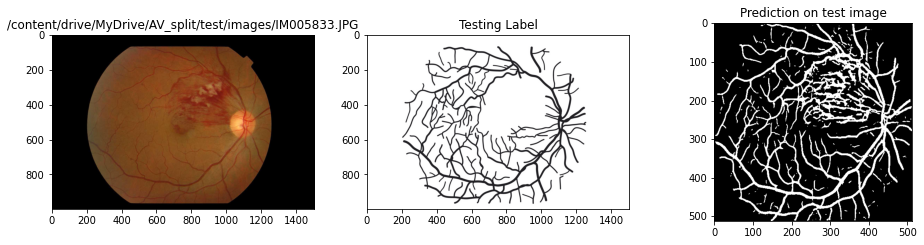

In [63]:
from datetime import datetime 

test_image_number = random.randint(0, len(test_image_list)-1)

reconstructed_image = []
test_img = cv2.imread(test_image_list[test_image_number])
gt = cv2.imread(test_vessel_mask_list[test_image_number])

predicted_patches = []
start = datetime.now()   

test = preprocess_image(test_img, PATCH_SIZE)
patches = patchify(test, (PATCH_SIZE, PATCH_SIZE), step=PATCH_SIZE) 

for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
          single_patch = patches[i,j,:,:]
          single_patch_norm = (single_patch.astype('float32')) 
          single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
          single_patch_input = np.expand_dims(single_patch_norm, 0)
          single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
          predicted_patches.append(single_patch_prediction)
          
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], PATCH_SIZE, PATCH_SIZE))

reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) 
reconstructed_image = cv2.resize(reconstructed_image, (512, 512))

stop = datetime.now()
print('Execution time: ',(stop-start)) #computation time

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title(test_image_list[test_image_number])
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(gt, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(reconstructed_image, cmap='gray')
plt.show()

(512, 512)
1 0
[0 1]


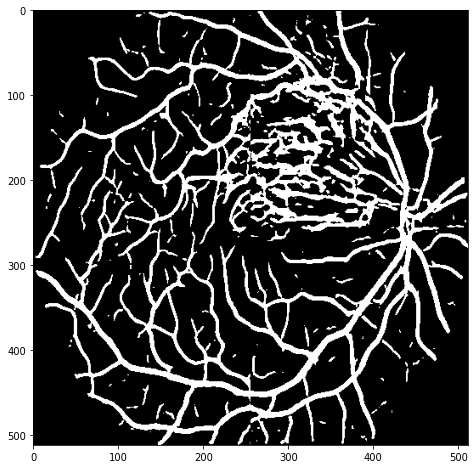

(512, 512, 1)
1 0
[0 1]


In [71]:
print(reconstructed_image.shape)
print(reconstructed_image.max(), reconstructed_image.min())
print(np.unique(reconstructed_image))

predicted_image = np.expand_dims(reconstructed_image, axis=-1)

plt.figure(figsize=(16, 8))
plt.imshow(predicted_image, cmap='gray')
plt.show()

print(predicted_image.shape)
print(predicted_image.max(), predicted_image.min())
print(np.unique(predicted_image))